# Training and evaluating encoding models

This tutorial introduces a typical encoding framework for mapping stimulus features onto brain activity during natural language comprehension. 

The previous tutorial walked through extracting two types of linguistic features: syntactic features and language model word embeddings. The `podcast-ecog` dataset comes with several other feature spaces as well. Encoding models ([Naselaris et al., 2011](https://www.sciencedirect.com/science/article/pii/S1053811910010657?via%3Dihub)) use linear regression to map these features onto brain activity. Here, we use the [Himalaya](https://gallantlab.org/himalaya/index.html) package ([Dupré La Tour et al., 2022](https://doi.org/10.1016/j.neuroimage.2022.119728)) to train these models using a ridge L2 penalty (also called ridge regression).

Acknowledgments: This tutorial draws heavily on the [encling tutorial](https://github.com/snastase/encling-tutorial/blob/main/encling_tutorial.ipynb) by Samuel A. Nastase.

First, we'll import the required Python packages.

In [1]:
import mne
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV
from himalaya.scoring import correlation_score

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

We will set the [Himalaya backend](https://gallantlab.org/himalaya/_generated/himalaya.backend.set_backend.html#himalaya.backend.set_backend) to `torch_cuda` so we can utilize a GPU for training, if available.

In [2]:
if torch.cuda.is_available():
    set_backend("torch_cuda")

## Loading features

We will now load two different features. The first is syntactic features constructed using spacy.io ([Honnibal et al., 2020](https://github.com/explosion/spaCy)). The second contains contextual word embeddings generated from GPT-2 ([Radford et al., 2019](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)). The loaded features should be a numpy array with a shape of (number of tokens * feature dimensions). Note that the numbers of tokens are different for the two features because of different tokenization schemas.

In [10]:
embedding_path = "../../monkey/stimuli/%s/states.hdf5"

# Syntactic features
with h5py.File(embedding_path % "syntactic", "r") as f:
    syntactic_features = f["vectors"][...]
print(f"Syntactic feature matrix has shape: {syntactic_features.shape}")

Syntactic feature matrix has shape: (5305, 96)


In [11]:
# Contextual word embeddings
modelname, layer = 'gpt2-xl', 24

with h5py.File(embedding_path % modelname, "r") as f:
    contextual_embeddings = f[f"layer-{layer}"][...]
print(f"LLM embedding matrix has shape: {syntactic_features.shape}")

LLM embedding matrix has shape: (5305, 96)


We will also load the stimuli transcripts associated with these features. Both transcripts should contain information about the word, token, start (onset), and end (offset). The contextual word embedding transcript should also include other prediction information extracted from GPT-2, like rank, probability, and entropy. For instance, we can calculate how accurate the model is in predicting the next token in the transcript based on the `rank` column, which are integers that represents the rank of the actual token in all the possible tokens of GPT-2.

Note: Check that the transcript contains the same number of tokens as the features we loaded before.

In [9]:
transcript_path = "../../monkey/stimuli/%s/transcript.tsv"

# Syntactic features transcript
df_syntactic = pd.read_csv(transcript_path % "syntactic", sep='\t', index_col=0)
df_syntactic.head()

(5305, 8)


,word_idx,word,start,end,token,pos,dep,stop
0,0,Act,3.710,3.790,Act,NNP,ROOT,False
1,1,"one,",3.990,4.190,one,CD,nummod,True
2,1,"one,",3.990,4.190,",",",",punct,False
3,2,monkey,4.651,4.931,monkey,NN,appos,False
4,3,in,4.951,5.011,in,IN,prep,True


In [8]:
# Contextual word embeddings transcript
df_contextual = pd.read_csv(transcript_path % modelname, sep="\t", index_col=0)

if "rank" in df_contextual.columns:
    model_acc = (df_contextual["rank"] == 0).mean()
    print(f"Model accuracy: {model_acc*100:.3f}%")

df_contextual.head()

Model accuracy: 30.942%
(5491, 10)


,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,ĠAct,2191,1644,0.000012,0,2.402717
1,1,"one,",3.990,4.190,Ġone,530,92,0.000342,352,3.732053
2,1,"one,",3.990,4.190,",",11,3,0.059520,25,4.259335
3,2,monkey,4.651,4.931,Ġmonkey,21657,4022,0.000018,3715,6.621269
4,3,in,4.951,5.011,Ġin,287,15,0.004237,0,4.444838


When we extracted features, some words are split into separate tokens. Since we only have information of start and end for words, we will align the features from tokens to words for encoding models. Here, we simply average the token features across the same word. Now the features should be a numpy array with a shape of (number of words * feature dimensions).

In [12]:
# Syntactic features
aligned_syntactic = []
for _, group in df_syntactic.groupby("word_idx"): # group by word index
    indices = group.index.to_numpy()
    average_syntactic = syntactic_features[indices].mean(0) # average features
    aligned_syntactic.append(average_syntactic)
aligned_syntactic = np.stack(aligned_syntactic)
print(f"Syntactic feature matrix has shape: {aligned_syntactic.shape}")

Syntactic feature matrix has shape: (5136, 96)


In [13]:
# Contextual word embeddings
aligned_embeddings = []
for _, group in df_contextual.groupby("word_idx"): # group by word index
    indices = group.index.to_numpy()
    average_emb = contextual_embeddings[indices].mean(0) # average features
    aligned_embeddings.append(average_emb)
aligned_embeddings = np.stack(aligned_embeddings)
print(f"LLM embeddings matrix has shape: {aligned_embeddings.shape}")

LLM embeddings matrix has shape: (5136, 1600)


We will also construct a dataframe containing words with their start and end timestamps.

In [14]:
df_word = df_contextual.groupby("word_idx").agg(dict(word="first", start="first", end="last"))
df_word.head()

,word,start,end
word_idx,,,
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111


In [15]:
# Since we need word start information for encoding, we will filter out words where the `start` timestamps are missing.

# good_mask = df_word['start'].notna().to_numpy()
# print(sum(good_mask))

# aligned_syntactic = aligned_syntactic[good_mask]
# aligned_embeddings = aligned_embeddings[good_mask]
# print(aligned_syntactic.shape)
# print(aligned_embeddings.shape)

5136
(5136, 96)
(5136, 1600)


## Loading brain data

Next, we will load the preprocessed high-gamma ECoG data using MNE. Here, we will demonstrate loading data from our third subject.

In [16]:
edf_path = BIDSPath(
    root="../../monkey/derivatives/ecogprep",
    subject="03",
    datatype="ieeg",
    description="highgamma",
    extension=".fif",
)
edf_path = edf_path.match()[0]

raw = mne.io.read_raw_fif(edf_path, verbose=False)
raw

<Raw | sub-03_task-monkey_desc-highgamma_ieeg.fif, 235 x 921600 (1800.0 s), ~275 kB, data not loaded>

We will map the start information (in seconds) of each word in the dataframe onto the brain signal data by multiplying by the sampling rate. Here the first column of `events` mark the start of each word on the brain signal data.

In [17]:
events = np.zeros((len(df_word), 3), dtype=int)
events[:, 0] = (df_word.start * raw.info['sfreq']).astype(int)
events.shape

(5136, 3)

Then we'll take advantage of MNE's tools for creating epochs around stimulus events, which here are the starts (onsets) of each word, to visualize brain signal that respond to word onsets. Here, we take a fixed-width window ranging from -2 seconds to +2 seconds relative to word onset. Since the sampling rate is 512 Hz (512 samples per second), we have 2049 lags total. The ECoG data is a numpy array with the shape of (number of words * number of ECoG electrodes * number of lags).

In [18]:
epochs = mne.Epochs(
    raw,
    events,
    tmin=-2.0,
    tmax=2.0,
    baseline=None,
    proj=False,
    event_id=None,
    preload=True,
    event_repeated="merge",
)
print(f"Epochs object has a shape of: {epochs._data.shape}")

Not setting metadata
5136 matching events found
No baseline correction applied
Loading data for 5136 events and 2049 original time points ...


/tmp/ipykernel_3688932/1833261107.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(


6 bad epochs dropped
ECoG data matrix shape: (5130, 235, 2049)


Next, we'll downsample the temporal resolution to 32 Hz, which reduces the number of lags to 32 * 4 = 128.

<div class="alert alert-info">

This code block may take ~3 minutes to run.

</div>

In [19]:
epochs = epochs.resample(sfreq=32, npad='auto', method='fft', window='hamming')
print(f"Epochs object has a shape of: {epochs._data.shape}")

Epochs object has a shape of: (5130, 235, 128)


## Setting up feature and brain data

Now we have both the features and the ECoG data ready. We plan to fit encoding models at each electrode and for each lag, so we'll reshape our target matrix `Y` to horizontally stack both electrodes and lags along the second dimension.

In [20]:
epochs_data = epochs.get_data(copy=True)
epochs_data = epochs_data.reshape(len(epochs), -1)
print(f"ECoG data matrix shape: {epochs_data.shape}")

ECoG data matrix shape: (5130, 30080)


We will also align our features with the ECoG data.

In [21]:
selected_df = df_word.iloc[epochs.selection]
averaged_syntactic = aligned_syntactic[epochs.selection]
averaged_embeddings = aligned_embeddings[epochs.selection]
print(averaged_syntactic.shape)
print(averaged_embeddings.shape)

(5130, 96)
(5130, 1600)


We will change the float precision to float32 for all data to take advantage of the GPU memory and computational speed.

In [22]:
X1 = averaged_syntactic
X2 = averaged_embeddings
Y = epochs_data

if "torch" in get_backend().__name__:
    X1 = X1.astype(np.float32)
    X2 = X2.astype(np.float32)
    Y = Y.astype(np.float32)

X1.shape, X2.shape, Y.shape

((5130, 96), (5130, 1600), (5130, 30080))

## Building encoding models

Now, we will use ridge regression to estimate the encoding model. We create a model pipeline uisng `sklearn`, which includes a [StandardScaler](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html) that standardizes features (X), and a [RidgeCV](https://gallantlab.org/himalaya/_generated/himalaya.ridge.RidgeCV.html) model, which performs ridge regression with cross-validation over our specificed alpha values.

In [23]:
alphas = np.logspace(1, 10, 10) # specify alpha values
inner_cv = KFold(n_splits=5, shuffle=False) # inner 5-fold cross-validation setup
model = make_pipeline(
    StandardScaler(), RidgeCV(alphas, fit_intercept=True, cv=inner_cv) # pipeline
)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10]),
                         cv=KFold(n_splits=5, random_state=None, shuffle=False),
                         fit_intercept=True))])

## Training encoding models

While `RidgeCV` contains an inner cross-validation setup to find the best alpha, we will also set up an outer cross-validation loop to evaluate our encoding model. Here, we will use k = 2, meaning we will train on half of the data and evaluate on the other half. Within each fold, we will split the train and test dataset. Then we will standardize `Y` the same way we standardize `X` in the pipeline. We will then fit our model on the training dataset and use it to predict for the testing dataset. For evaluation, we will calculate correlation scores between `Y_preds`, the ECoG signal predicted by our model, and `Y_test`, the actual ECoG signal. The encoding model is trained and evaluated for each electrode and each lag.

<div class="alert alert-info">

This code block may take a while to run. Make sure you are using a GPU if you have one (verify by running `nvidia-smi`). You may also consider resampling the epochs even further to use fewer lags, and/or choose specific electrodes to run to use fewer electrodes.

</div>

In [24]:
epochs_shape = epochs._data.shape[1:] # number of electrodes * number of lags

def train_encoding(X, Y):

    corrs = [] # empty array to store correlation results
    kfold = KFold(2, shuffle=False) # outer 2-fold cross-validation setup
    for train_index, test_index in kfold.split(X): # loop through folds

        # Split train and test datasets
        X1_train, X1_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Standardize Y
        scaler = StandardScaler()
        Y_train = scaler.fit_transform(Y_train)
        Y_test = scaler.transform(Y_test)

        model.fit(X1_train, Y_train) # Fit pipeline with transforms and ridge estimator
        Y_preds = model.predict(X1_test) # Use trained model to predict on test set
        corr = correlation_score(Y_test, Y_preds).reshape(epochs_shape) # Compute correlation score

        if "torch" in get_backend().__name__: # if using gpu, transform tensor back to numpy
            corr = corr.numpy(force=True)

        corrs.append(corr) # append fold correlation results to final results
    return np.stack(corrs)

# set_backend("torch") # resort to torch or numpy if cuda out of memory
# corrs_syntactic = train_encoding(X1, Y)
corrs_embedding = train_encoding(X2, Y)

In [28]:
corrs_embedding.shape

(2, 235, 128)

## Plotting encoding lag results

Now we can plot the correlations for one electrode on all lags. We use `LGA10` as an example. We will plot the correlation for the syntactic features as blue and the correlation for the contextual word embeddings as red.

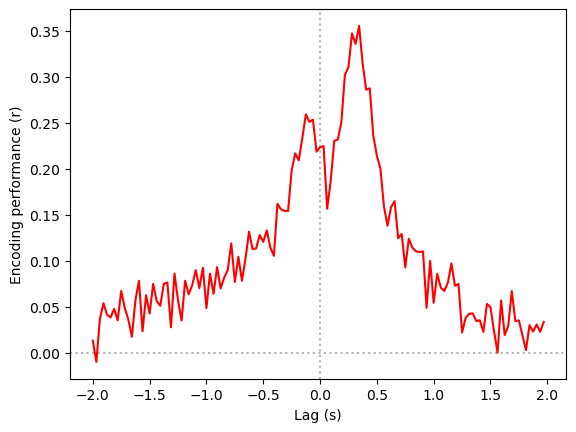

In [25]:
lags = np.arange(-2 * 512, 2 * 512, 16) / 512 # specify the lags

electrode = "LGA10"
electrode_id = raw.info["ch_names"].index(electrode) # get electrode index

plt.axvline(0, c="k", alpha=0.3, ls=":")
plt.axhline(0, c="k", alpha=0.3, ls=":")
# plt.plot(lags, corrs_syntactic.mean(0)[electrode_id], c="b") # blue line
plt.plot(lags, corrs_embedding.mean(0)[electrode_id], c="r") # red line
plt.xlabel("Lag (s)")
plt.ylabel("Encoding performance (r)")
plt.show()

## Plotting encoding brainplots

We can also plot the max correlations for all electrodes on the brain. We will first get the coordinates of all electrodes from the raw ECoG data, resulting in `coords` with the shape of (number of electrodes * 3), where each electrode has a 3-dimensional MNI coordinate relative to the brain surface.

In [26]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
coords.shape

(235, 3)

We will take the max correlation for each electrode. Then, we will use the nilearn [`plot_markers`](https://nilearn.github.io/dev/modules/generated/nilearn.plotting.plot_markers.html#nilearn.plotting.plot_markers) function to plot electrodes on top of the brain glass schematics. To compare the encoding performance of our syntactic features and contextual word embeddings, we use the same colorbar scale for both brainplots.

Coordinate matrix shape:  (235, 3)


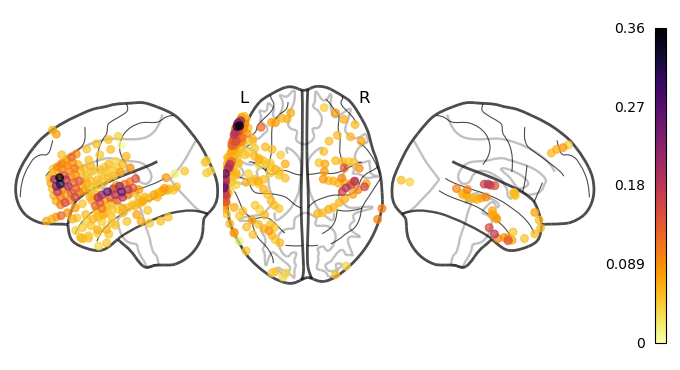

In [27]:
values = corrs_embedding.mean(0).max(-1)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = values.argsort()
plot_markers(values[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()